# Import Package, and Func.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import qiskit.quantum_info as qi

#from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature import settings
from qiskit_algorithms.optimizers import  SPSA, COBYLA, L_BFGS_B
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
import pickle


In [2]:
def reset_intermediate_info():
    global intermediate_info
    intermediate_info.clear()
    print(intermediate_info)
    intermediate_info = {
        'nfev ': [],
        'parameters ': [],
        'energy ': [],
        'stddev ': []
    }


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

def fermion_to_qubit(problem, second_q_op, mapper_name,  z2symmetry_reduction=None):
  if mapper_name == "JW":
    mapper = JordanWignerMapper()
  if mapper_name == "Pa":
    mapper = ParityMapper(num_particles=problem.num_particles)
  if mapper_name == "BK":
    mapper = BravyiKitaevMapper()

  qubit_op = mapper.map(second_q_op)

  if z2symmetry_reduction != None:
    mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(second_q_op)
  else :
    qubit_op = mapper.map(second_q_op)

  return qubit_op , mapper

def callback (nfev , parameters , energy , stddev ):
    intermediate_info ['nfev ']. append ( nfev )
    intermediate_info ['parameters ']. append ( parameters )
    intermediate_info ['energy ']. append ( energy )
    intermediate_info ['stddev ']. append ( stddev )



def least_Energy(as_problem,molecule_name):
    as_num_particles = as_problem.num_particles
    as_num_spatial_orbitals = as_problem.num_spatial_orbitals
    as_fermionic_hamiltonian = as_problem.hamiltonian
    as_second_q_op = as_fermionic_hamiltonian.second_q_op()
    energy_arr = []
    ansatz_order = []
    opt_order=[]
    qubit_op, mapper = fermion_to_qubit(as_problem, as_second_q_op, "Pa", z2symmetry_reduction=None)
    as_init_state = HartreeFock(as_num_spatial_orbitals,as_num_particles,mapper)
    uccsd = UCCSD(as_num_spatial_orbitals,as_num_particles,mapper,initial_state=as_init_state, generalized=True)
    twolocal = TwoLocal(as_num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=as_init_state)
    ansatzs=[uccsd,twolocal]
    iter = [250,1000]
    ansatzs_name=['UCCSD','Two local']
    
    opt_names = ['COBYLA','SPSA','L-BFGS-B'] 
    noiseless_estimator = Estimator()
    for i in range(2):
        ansatz = ansatzs[i]
        ansatz_name= ansatzs_name[i]
        MAX_ITER = iter[i]
        opt_arr = [COBYLA(maxiter=MAX_ITER),SPSA(maxiter=MAX_ITER),L_BFGS_B(maxiter=MAX_ITER)]
        for k in range(3):
            reset_intermediate_info()
            optimizer = opt_arr[k]
            opt_name = opt_names[k]
            vqe = VQE(noiseless_estimator, ansatz, optimizer, callback = callback)
            result = vqe.compute_minimum_eigenvalue(qubit_op)
            # electronic_structure_result = as_problem.interpret(result)

            core = as_problem.hamiltonian.constants['ActiveSpaceTransformer']
            repulsion = as_problem.hamiltonian.constants['nuclear_repulsion_energy']

            vqe_result = result.eigenvalue.real #+shift

            exact_energy = exact_solver(qubit_op, as_problem).total_energies[0].real

            # convergence_energy = intermediate_info['energy '][-1]
            dimer_energy = vqe_result+repulsion + core
            Co_Li_energy = dimer_energy

            energy_arr.append(Co_Li_energy)
            ansatz_order.append(ansatz_name)
            opt_order.append(opt_name)
            
            plt.plot(range(len(intermediate_info['energy '])), intermediate_info['energy ']+repulsion + core )
            plt.axhline(exact_energy, color = 'r', linewidth = 1, label = 'exact energy')
            plt.title('{0},{1}'.format(ansatz_name , opt_name))
            plt.xlabel('VQE Iterations')
            plt.ylabel('Energy')
            plt.grid()
            plt.legend()
            plt.show()
    
    return energy_arr, ansatz_order, opt_order

In [ ]:
intermediate_info = {
'nfev ': [],
'parameters ': [],
'energy ': [],
'stddev ': []
}

basis = 'sto3g'
settings.use_pauli_sum_op = False


C = 1.9032
L = 2.07
theta = np.deg2rad(95.24)

Co = (0,0,0)
O_1 = (C,0,0)
O_2 = (C*np.cos(theta),C*np.sin(theta),0)
Li = (C+L*np.cos(np.pi-theta),-L*np.sin(np.pi-theta),0)

# Energy calc.

## 1. O-Li(near, bonding)

{}


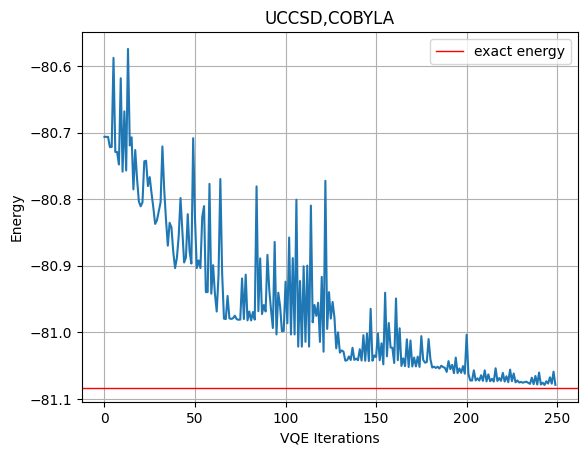

{}


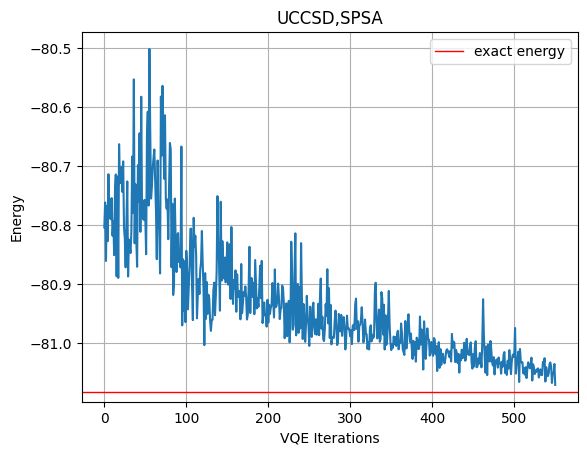

{}


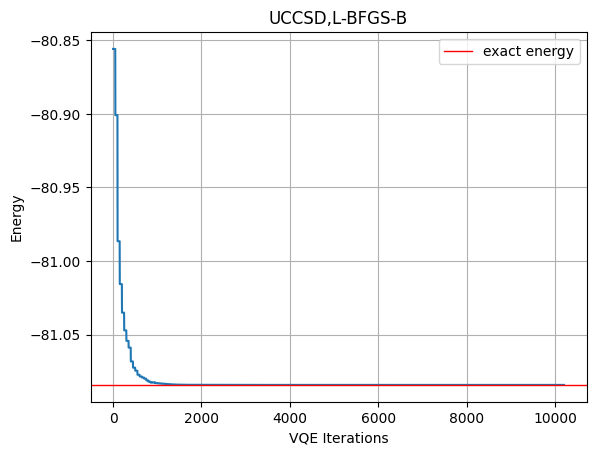

{}


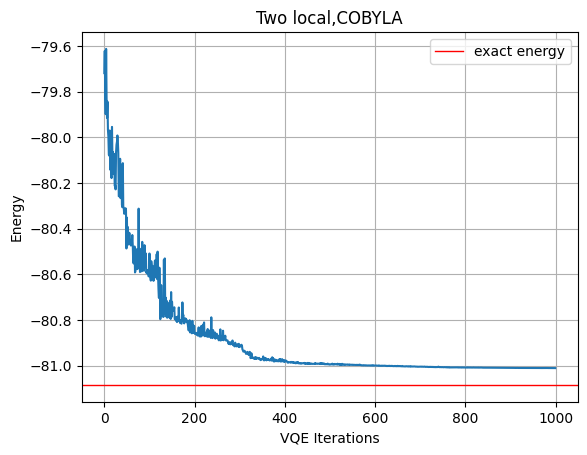

{}


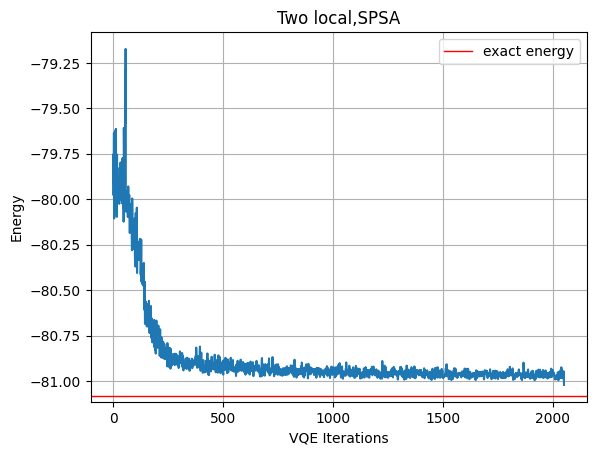

{}


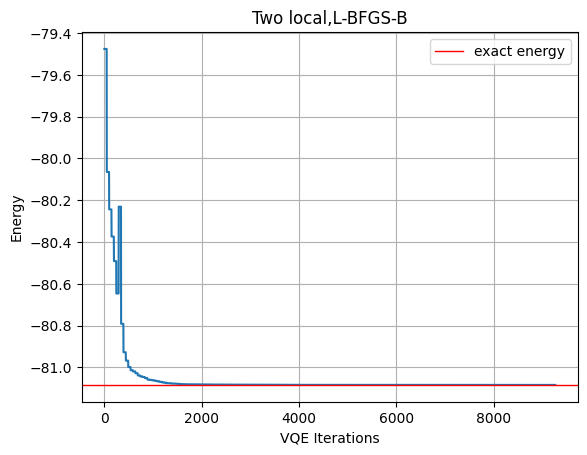

[-81.0790659354052, -81.071381609814, -81.08408496306862, -81.01048935792933, -81.02048344435063, -81.08404331948476]
optimal_calc :
anstaz:  UCCSD
optimizer:  L-BFGS-B
Energy:  -81.08408496306862


In [4]:
molecule_name = 'O-Li'

O_Li_dimer_atoms = ["O", "Li"]
O_Li_dimer_coords = [O_1, Li]
O_Li_dimer_charge = 0
O_Li_dimer_multiplicity = 2

O_Li_moleculeinfo = MoleculeInfo(O_Li_dimer_atoms, O_Li_dimer_coords, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)

energy_arr =[]
order=[]
driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((3,2), 4)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem, molecule_name=molecule_name)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)
        
O_Li_dimer_energy=e

## 5. Co=O (Double bonding)

{}


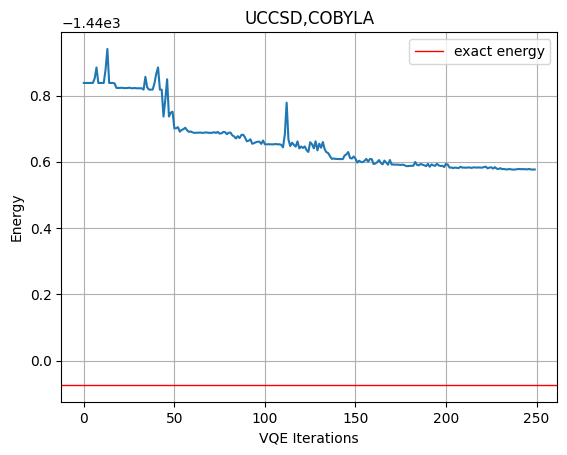

{}


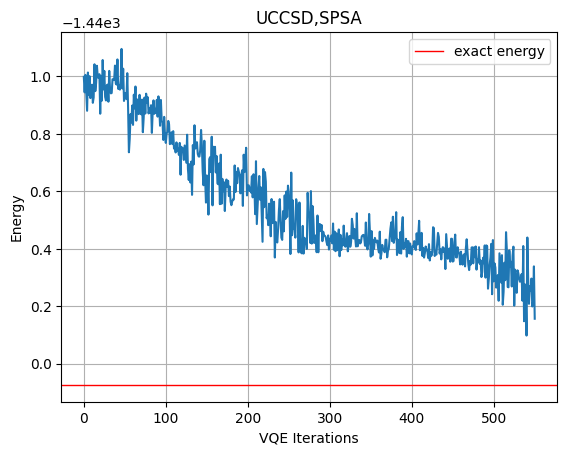

{}


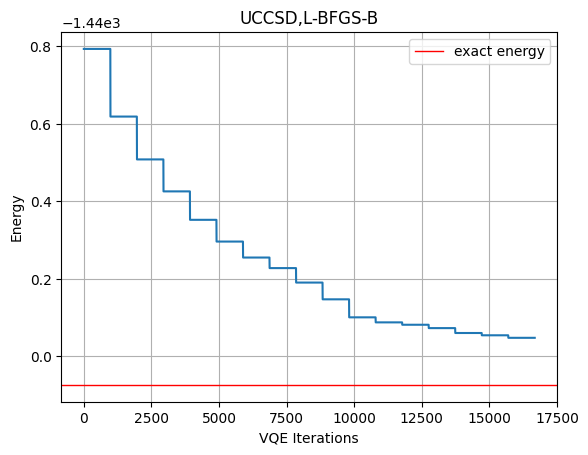

{}


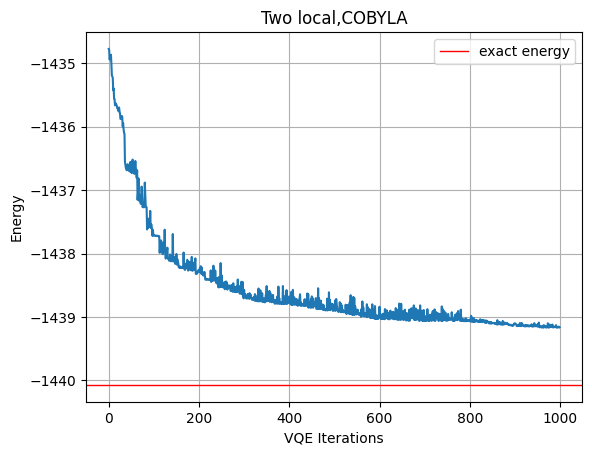

{}


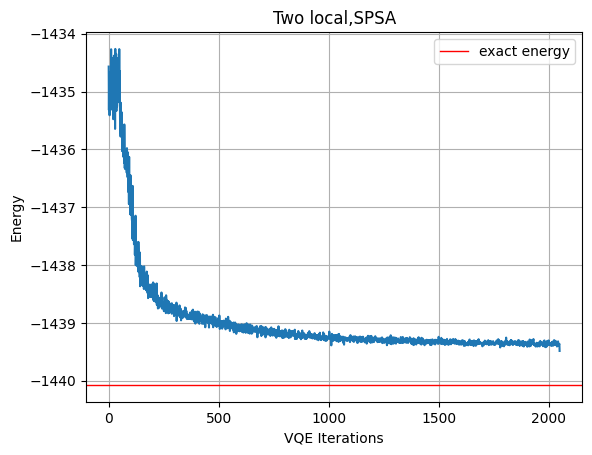

{}


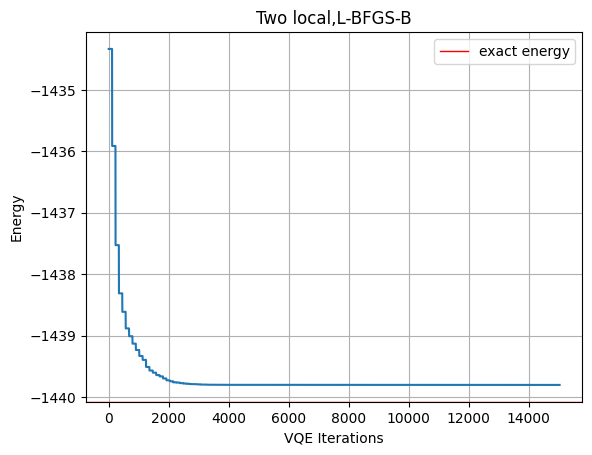

[-1439.4236606996062, -1439.8433167922262, -1439.9520273812586, -1439.1698800685797, -1439.4858841217283, -1439.8033934091552]
optimal_calc :
anstaz:  UCCSD
optimizer:  L-BFGS-B
Energy:  -1439.9520273812586


In [5]:
molecule_name = 'Co=O'

Co_O_dimer_atoms = ["Co", "O"]
Co_O_dimer_coords = [Co, O_2]
Co_O_dimer_charge = 0
Co_O_dimer_multiplicity = 2
Co_O_moleculeinfo = MoleculeInfo(Co_O_dimer_atoms, Co_O_dimer_coords, charge=Co_O_dimer_charge, multiplicity=Co_O_dimer_multiplicity)
energy_arr =[]
order=[]
driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((6,5), 8)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem, molecule_name=molecule_name)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)
Co_O_2_dimer_energy=e

## 6.  Co-O (Single bonding)

{}


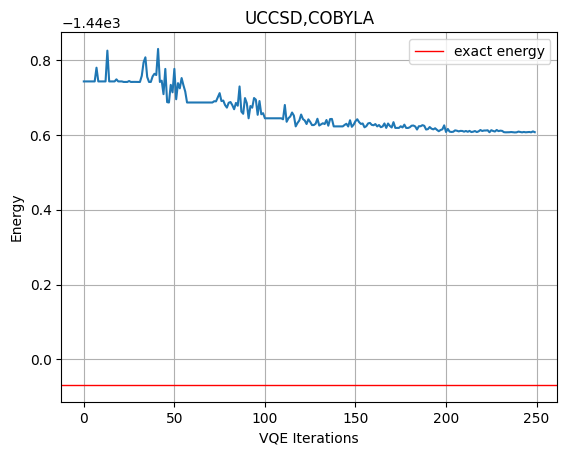

{}


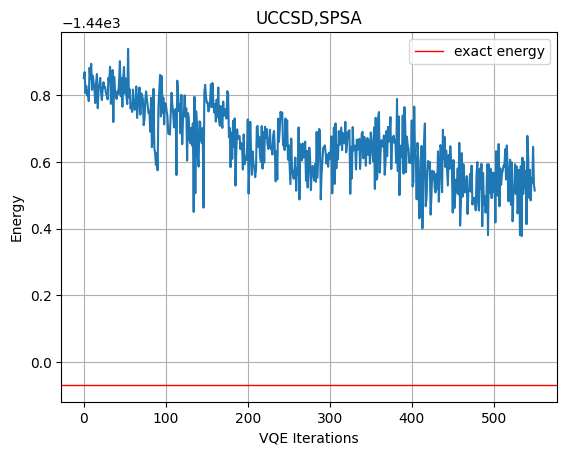

{}


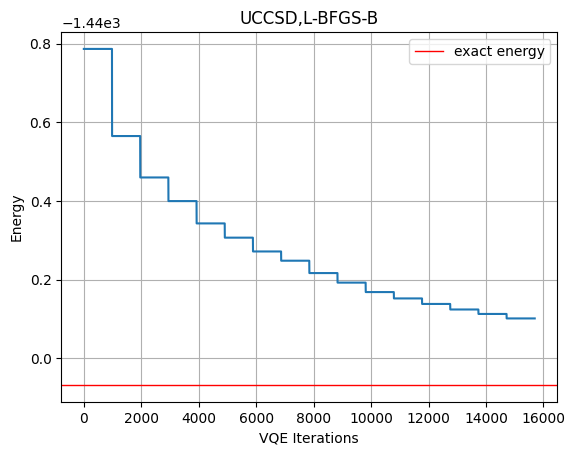

{}


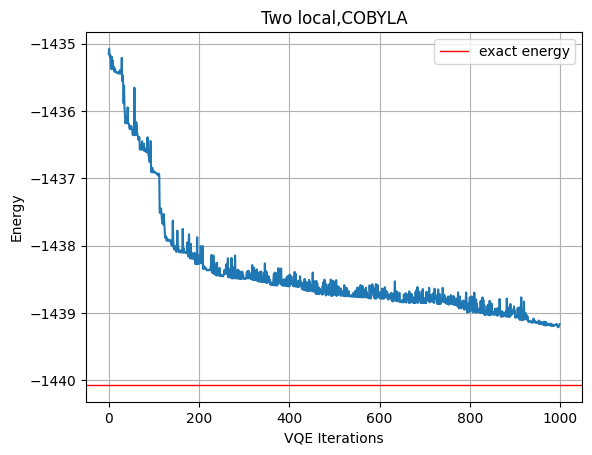

{}


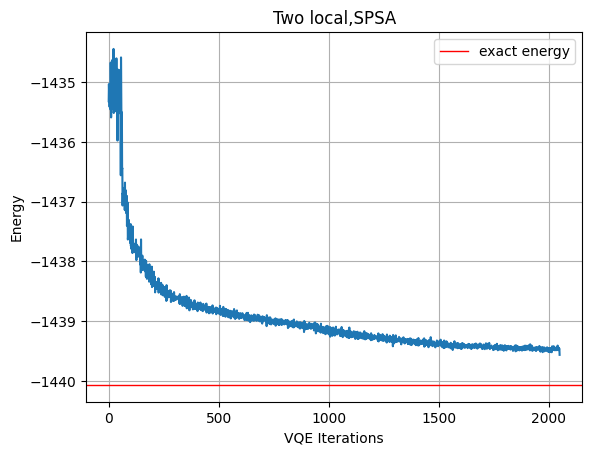

{}


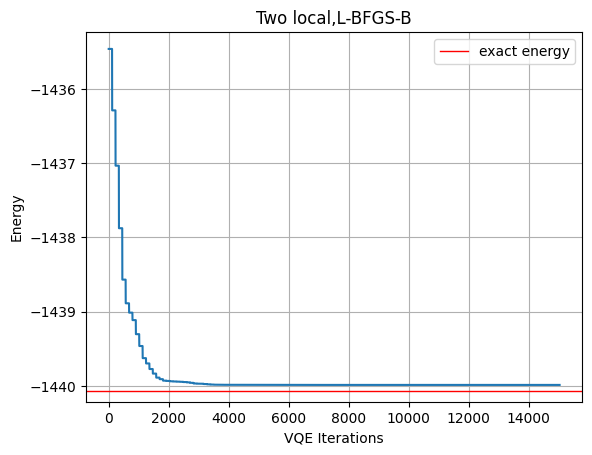

[-1439.3936348400266, -1439.4857195416375, -1439.8988480913445, -1439.210820510639, -1439.564247338823, -1439.9860584316934]
optimal_calc :
anstaz:  Two local
optimizer:  L-BFGS-B
Energy:  -1439.9860584316934


In [6]:
molecule_name = 'Co-O'

Co_O_dimer_atoms = ["Co", "O"]
Co_O_dimer_coords = [Co, O_1]
Co_O_dimer_charge = 0
Co_O_dimer_multiplicity = 4
Co_O_moleculeinfo = MoleculeInfo(Co_O_dimer_atoms, Co_O_dimer_coords, charge=Co_O_dimer_charge, multiplicity=Co_O_dimer_multiplicity)
energy_arr =[]
order=[]
driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((7,4), 8)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem, molecule_name=molecule_name)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)
        
Co_O_1_dimer_energy=e

## 1. O-Li(near, bonding)

{}


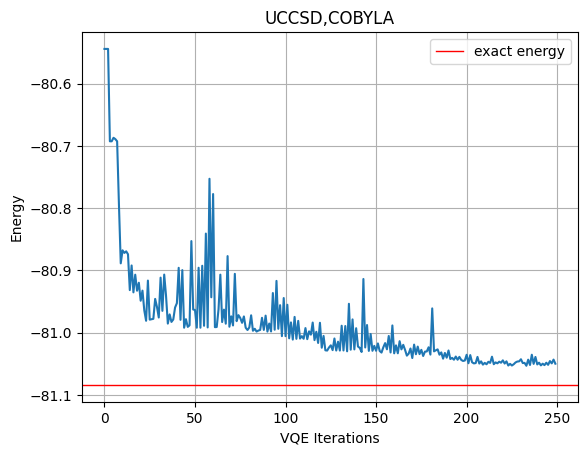

{}


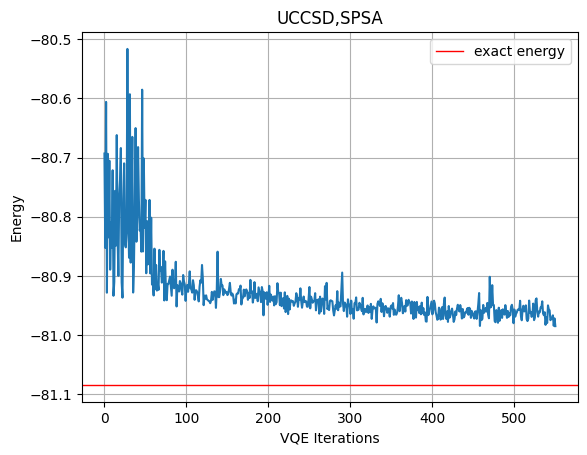

{}


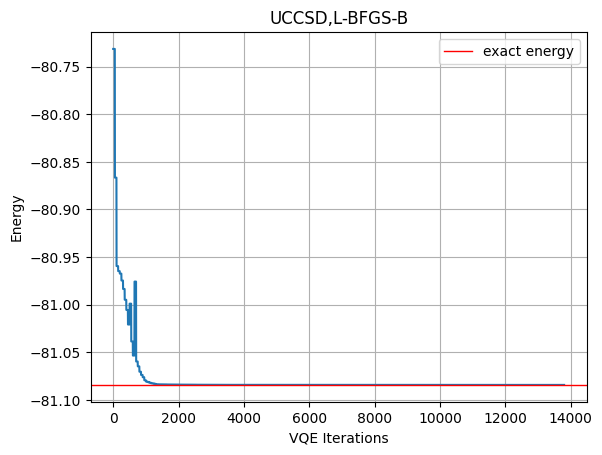

{}


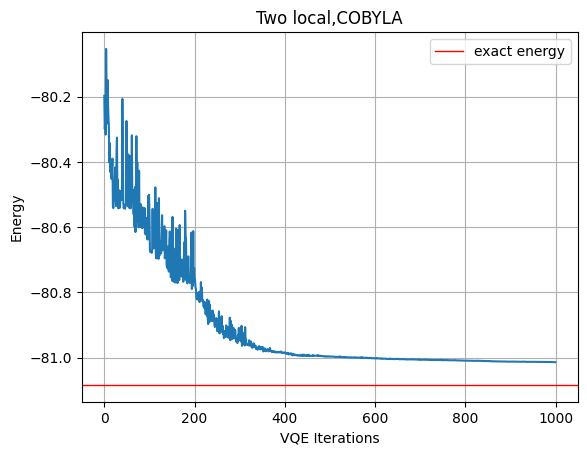

{}


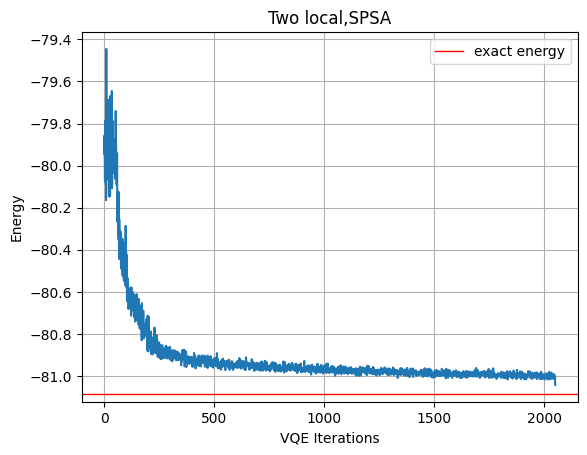

{}


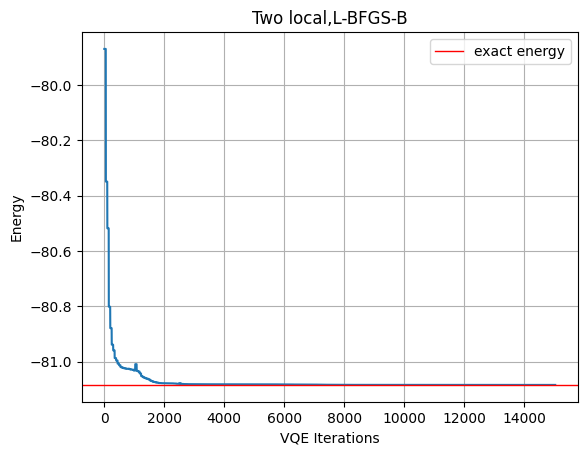

[-81.05329592044343, -80.98481452354167, -81.08408454242362, -81.0143154451011, -81.0422716310578, -81.08406026416398]
optimal_calc :
anstaz:  UCCSD
optimizer:  L-BFGS-B
Energy:  -81.08408454242362


In [7]:
molecule_name = 'Li-O'

O_Li_dimer_atoms = ["O", "Li"]
O_Li_dimer_coords = [O_1, Li]
O_Li_dimer_charge = 0
O_Li_dimer_multiplicity = 2

O_Li_moleculeinfo = MoleculeInfo(O_Li_dimer_atoms, O_Li_dimer_coords, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)

energy_arr =[]
order=[]
driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((3,2), 4)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem, molecule_name=molecule_name)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)
        
O_Li_dimer_energy=e


## 2. O--Li(far, non-bonding)

{}


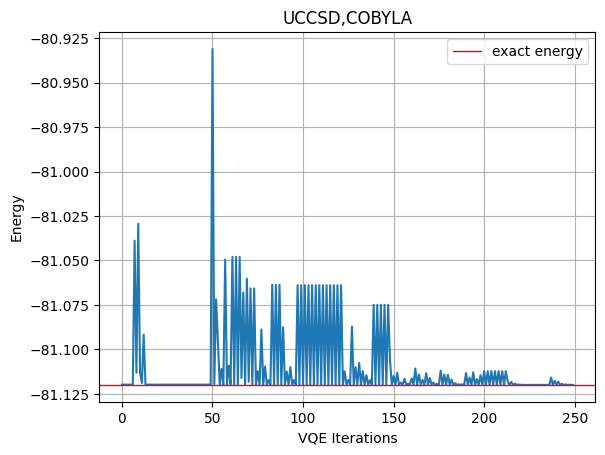

{}


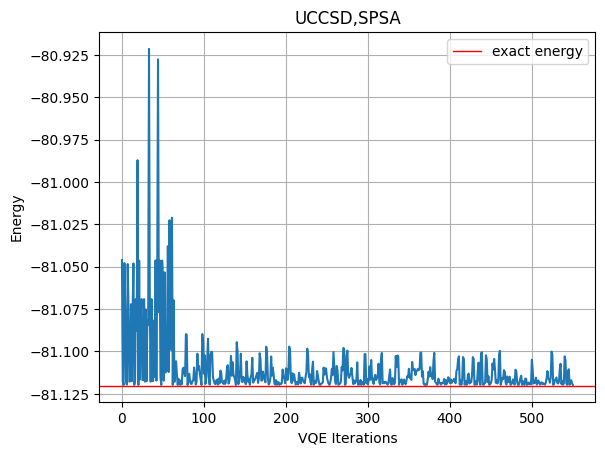

{}


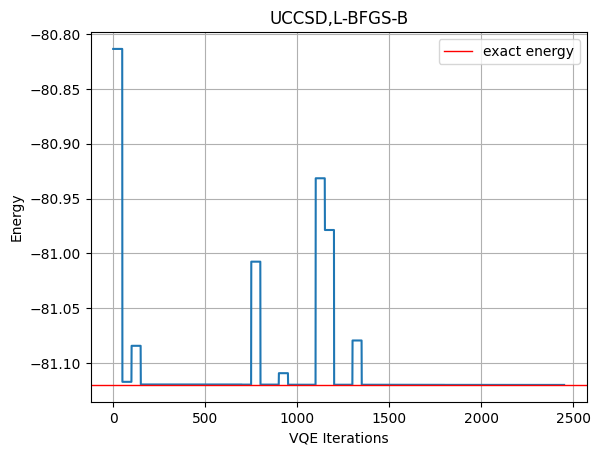

{}


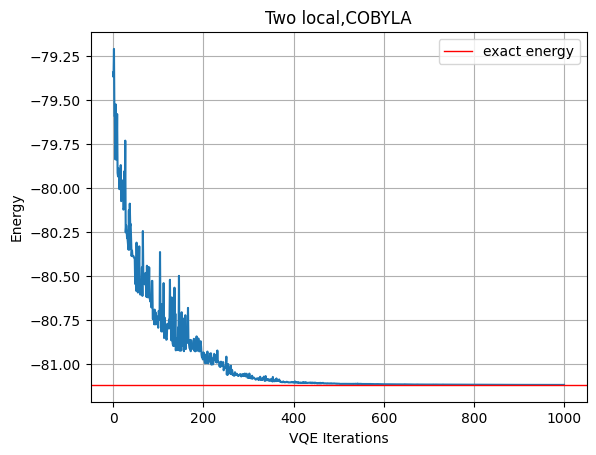

{}


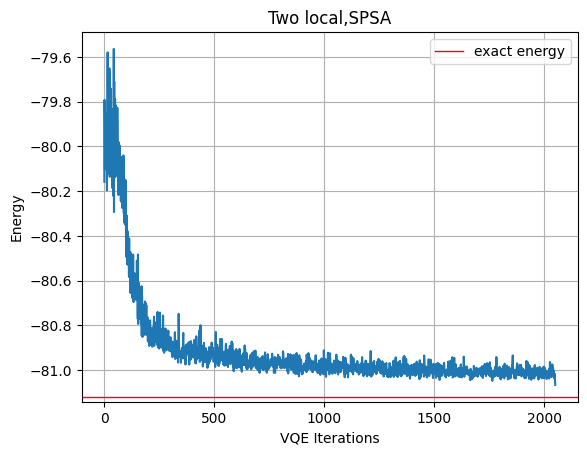

{}


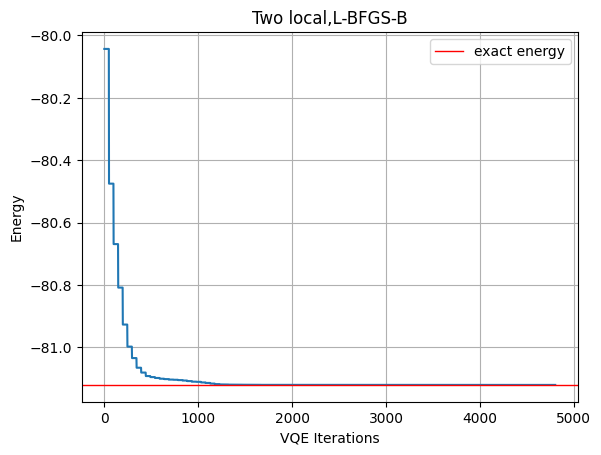

[-81.11999177943798, -81.11969899549251, -81.120070864847, -81.11775827181368, -81.06677202246652, -81.1200708623512]
optimal_calc :
anstaz:  UCCSD
optimizer:  L-BFGS-B
Energy:  -81.120070864847


In [8]:
molecule_name = 'Li~O'

O_Li_dimer_atoms = ["O", "Li"]
O_Li_dimer_coords = [O_2, Li]
O_Li_dimer_charge = 0
O_Li_dimer_multiplicity = 4

O_Li_moleculeinfo = MoleculeInfo(O_Li_dimer_atoms, O_Li_dimer_coords, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)

driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((4,1), 4)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem, molecule_name=molecule_name)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)

O_Li_2_dimer_energy=e

## 3. Co-Li (non-bonding)

{}


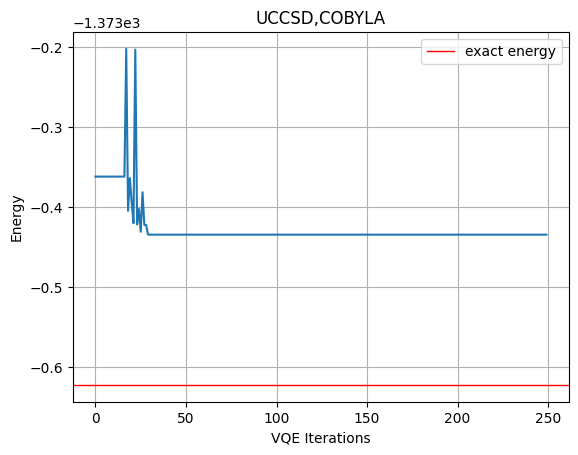

{}


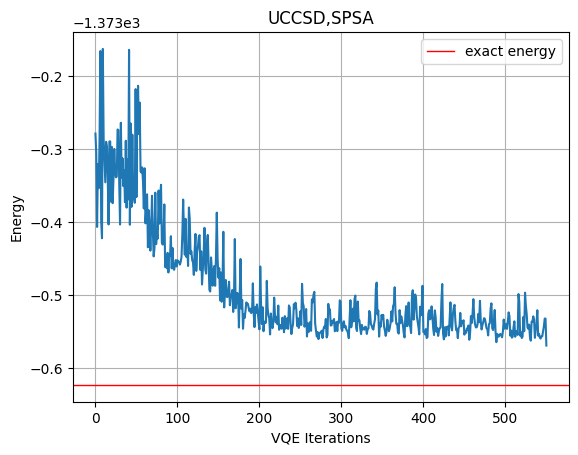

{}


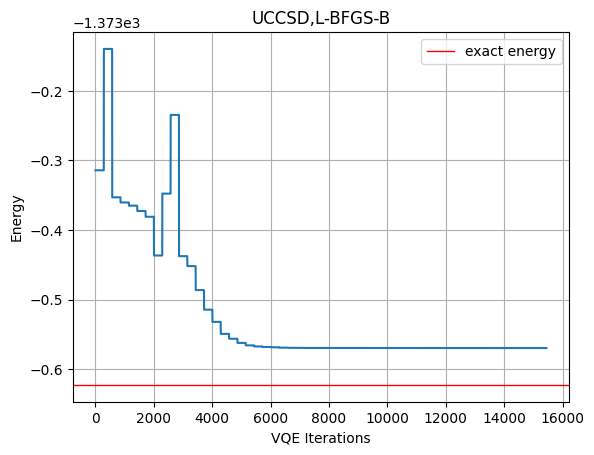

{}


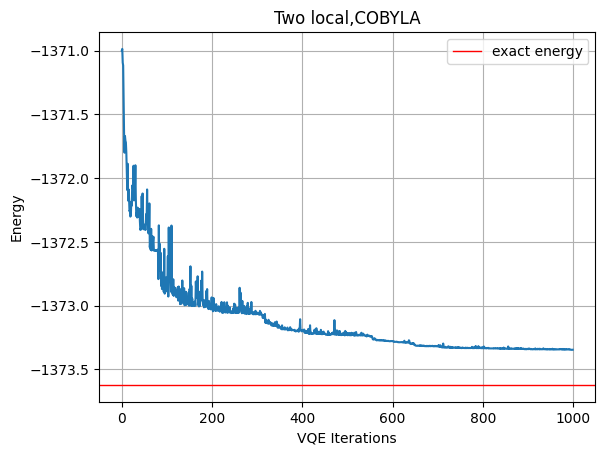

{}


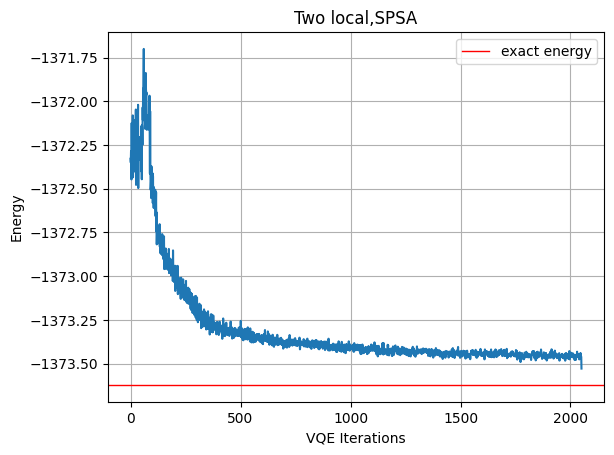

{}


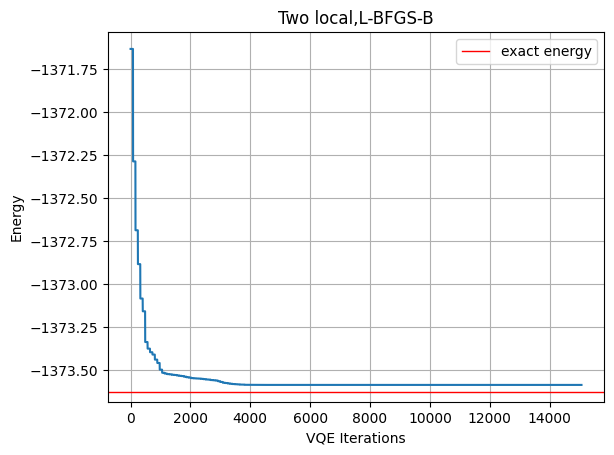

[-1373.4346777065832, -1373.5686484455716, -1373.5695090361162, -1373.3473013444113, -1373.5290099857073, -1373.58423605959]
optimal_calc :
anstaz:  Two local
optimizer:  L-BFGS-B
Energy:  -1373.58423605959


In [9]:
molecule_name = 'Co~Li'

Co_Li_dimer_atoms = ["Co", "Li"]
Co_Li_dimer_coords = [Co, Li]
Co_Li_dimer_charge = 0
Co_Li_dimer_multiplicity = 5
energy_arr =[]
order=[]
Co_Li_moleculeinfo = MoleculeInfo(Co_Li_dimer_atoms, Co_Li_dimer_coords, charge=Co_Li_dimer_charge, multiplicity=Co_Li_dimer_multiplicity)

driver = PySCFDriver.from_molecule(Co_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((6,2), 6)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem, molecule_name=molecule_name)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)

Co_Li_dimer_energy=e

## 4. O-O

{}


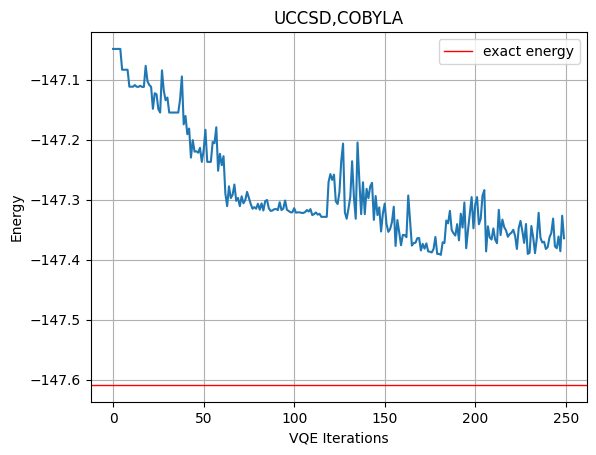

{}


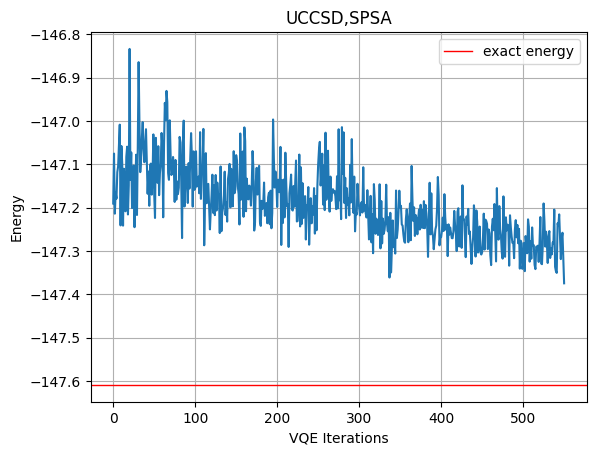

{}


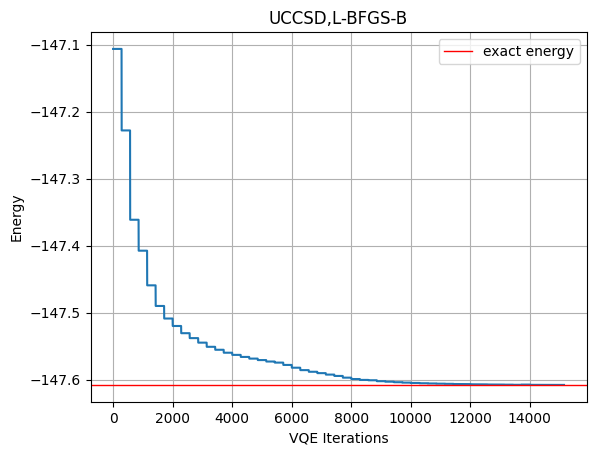

{}


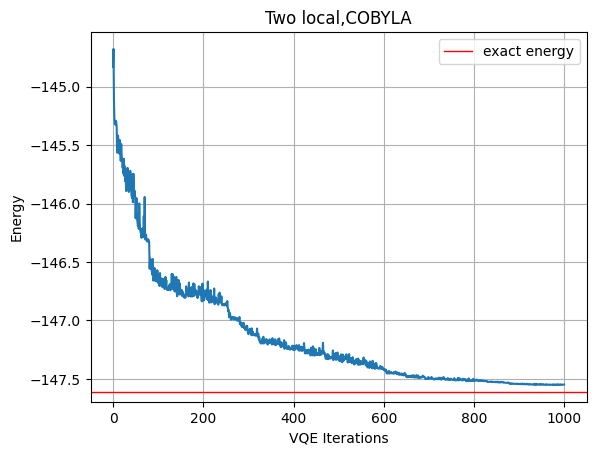

{}


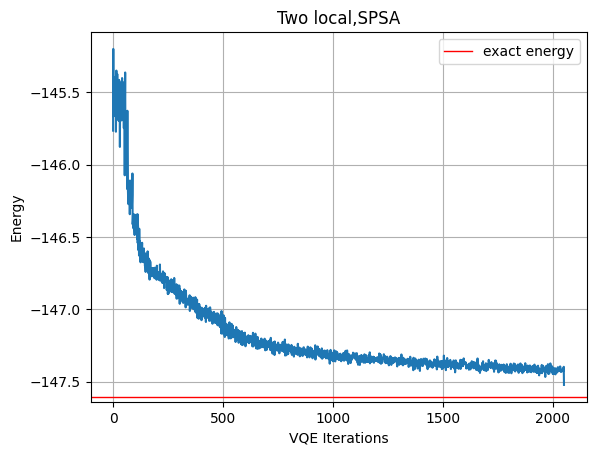

{}


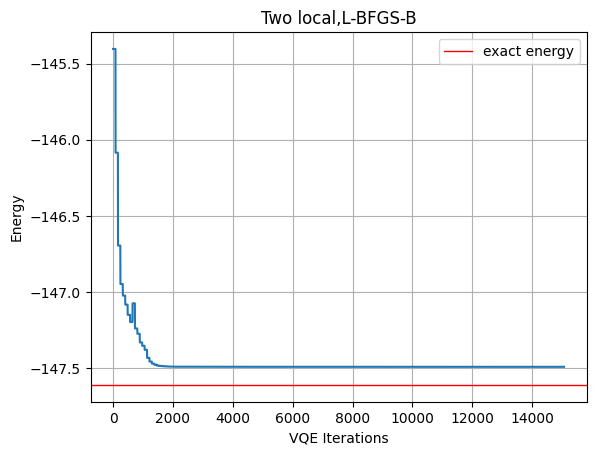

[-147.39197410832475, -147.37439254173688, -147.60804161345004, -147.55175876303866, -147.52359741987743, -147.48999242468292]
optimal_calc :
anstaz:  UCCSD
optimizer:  L-BFGS-B
Energy:  -147.60804161345004


In [10]:
molecule_name = 'O~O'

O_O_dimer_atoms = ["O", "O"]
O_O_dimer_coords = [O_1, O_2]
O_O_dimer_charge = 0
O_O_dimer_multiplicity = 3
energy_arr =[]
order=[]
O_O_moleculeinfo = MoleculeInfo(O_O_dimer_atoms, O_O_dimer_coords, charge=O_O_dimer_charge, multiplicity=O_O_dimer_multiplicity)

driver = PySCFDriver.from_molecule(O_O_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((6,2), 6)
as_problem = as_transformer.transform(E_problem)
energy_arr, ansatz_order, opt_order = least_Energy(as_problem, molecule_name=molecule_name)

print(energy_arr)

for k in range(len(energy_arr)):
    e=energy_arr[k]
    if e == np.min(energy_arr):
        print('optimal_calc :')
        print('anstaz: ', ansatz_order[k])
        print('optimizer: ', opt_order[k])
        print('Energy: ', e)
        
O_O_dimer_energy=e

## FMO Calc.

In [11]:
dimer_energy_arr = [O_Li_dimer_energy,O_Li_2_dimer_energy,Co_O_1_dimer_energy,Co_O_2_dimer_energy,O_O_dimer_energy,Co_Li_dimer_energy]

O_mon= -74.78751
Co_mon = -1381.35417
Li_mon = -7.43241

FMO_VQE_energy = np.sum(dimer_energy_arr) - 2*(O_mon+Co_mon+Li_mon+O_mon)

Co_O_Li_energy = (Co_O_1_dimer_energy+Co_O_2_dimer_energy+O_O_dimer_energy)-(O_mon+Co_mon+O_mon)

def E(x):
    return x*FMO_VQE_energy + (1-x)*Co_O_Li_energy


x=1
calc_energy = E(x)



print(dimer_energy_arr)
print("FMO_VQE_energy", FMO_VQE_energy)
print("calc_energy", calc_energy)

[-81.08406026416398, -81.1200708623512, -1439.9860584316934, -1439.8033934091552, -147.48999242468292, -1373.58423605959]
FMO_VQE_energy -1486.3446114516364
calc_energy -1486.3446114516364
